<a href="https://colab.research.google.com/github/robbianiandrea/focs/blob/main/Progetto_Andrea_Robbiani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

In [4]:
sns.set(style="whitegrid")

In [5]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [6]:
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("estratto")

csv_path = "estratto/dataset.csv"
df = pd.read_csv(csv_path, parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

In [7]:
# 1. Extract all trips with trip_distance larger than 50
long_trips = df[df["trip_distance"] > 50]

In [8]:
# 2. Extract all trips where payment_type is missing
missing_payment = df[df["payment_type"].isna()]

In [9]:
#3. For each (PULocationID, DOLocationID) pair, determine the number of trips
trip_counts = df.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="trip_count")
top_pairs = trip_counts.sort_values("trip_count", ascending=False).head(10)

In [10]:
#4. Save all rows with missing VendorID, passenger_count, store_and_fwd_flag, payment_type in a new dataframe called bad, and remove those rows from the original dataframe.
bad = df[df[["VendorID", "passenger_count", "store_and_fwd_flag", "payment_type"]].isna().any(axis=1)]
df = df.drop(bad.index)

In [11]:
#5. Add a duration column storing how long each trip has taken (use tpep_pickup_datetime, tpep_dropoff_datetime)
df["duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

In [12]:
# Check if there are rows where tpep_pickup_datetime > tpep_dropoff_datetime, and if so, I remove them
df[df["tpep_pickup_datetime"] > df["tpep_dropoff_datetime"]]
df = df[df["tpep_pickup_datetime"] <= df["tpep_dropoff_datetime"]]

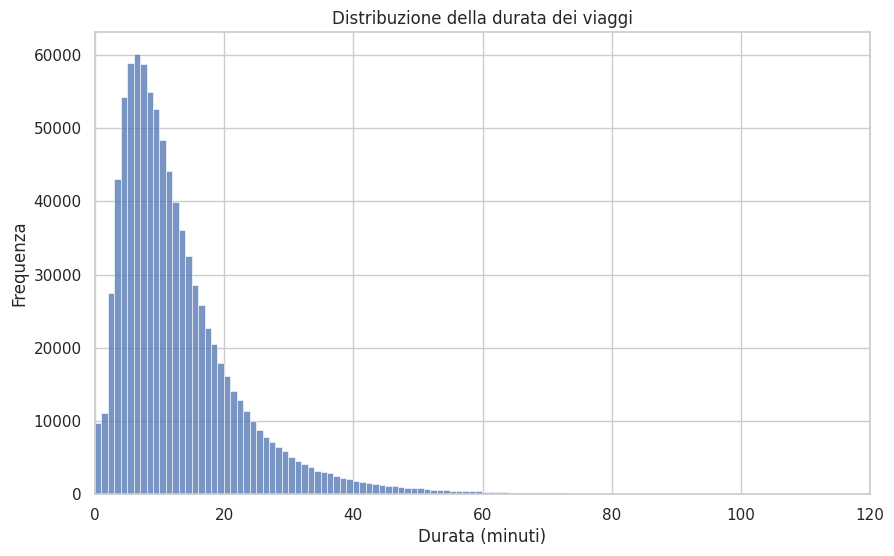

In [13]:
# Visualization of the trip durations"
plt.figure(figsize=(10, 6))
sns.histplot(df[df["duration"] <= 120]["duration"], bins=120)
plt.title("Distribuzione della durata dei viaggi")
plt.xlabel("Durata (minuti)")
plt.ylabel("Frequenza")
plt.xlim(0, 120)
plt.show()

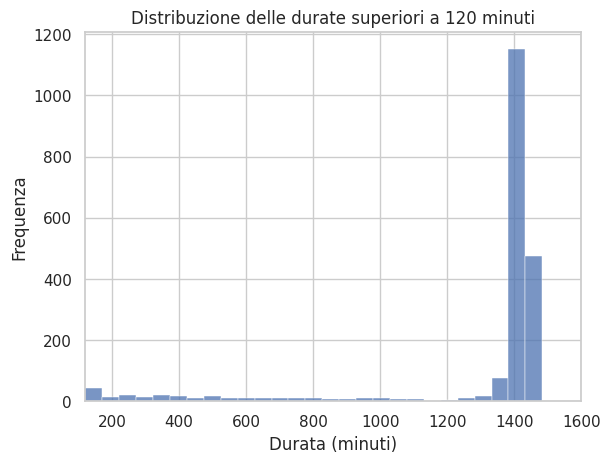

In [14]:
# histogram for duration>120
sns.histplot(df[df["duration"] > 120]["duration"], bins=100)
plt.title("Distribuzione delle durate superiori a 120 minuti")
plt.xlabel("Durata (minuti)")
plt.ylabel("Frequenza")
plt.xlim(120, 1600)
plt.show()

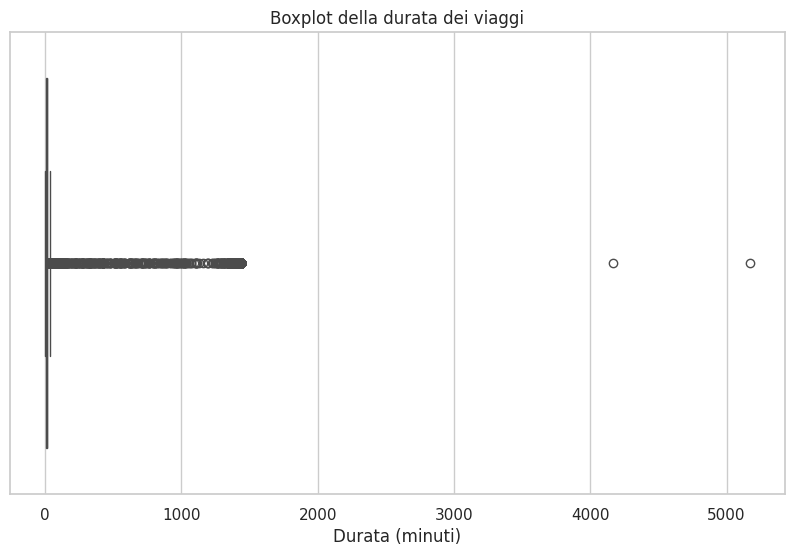

In [15]:
#boxplot of trip duration (da capire se lasciare)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["duration"])
plt.title("Boxplot della durata dei viaggi")
plt.xlabel("Durata (minuti)")
plt.show()

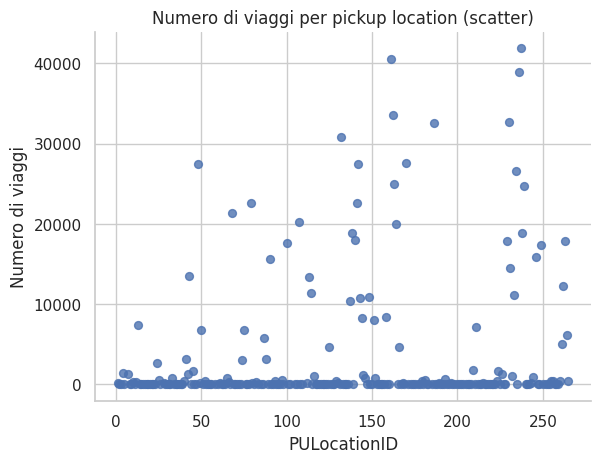

In [16]:
#6 For each pickup location, determine how many trips have started there
pickup_counts = df["PULocationID"].value_counts().reset_index(name="trip_count").rename(columns={"index": "PULocationID"})
pickup_counts.plot(kind='scatter', x='PULocationID', y='trip_count', s=32, alpha=0.8)
plt.title("Numero di viaggi per pickup location (scatter)")
plt.xlabel("PULocationID")
plt.ylabel("Numero di viaggi")
plt.grid(True)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

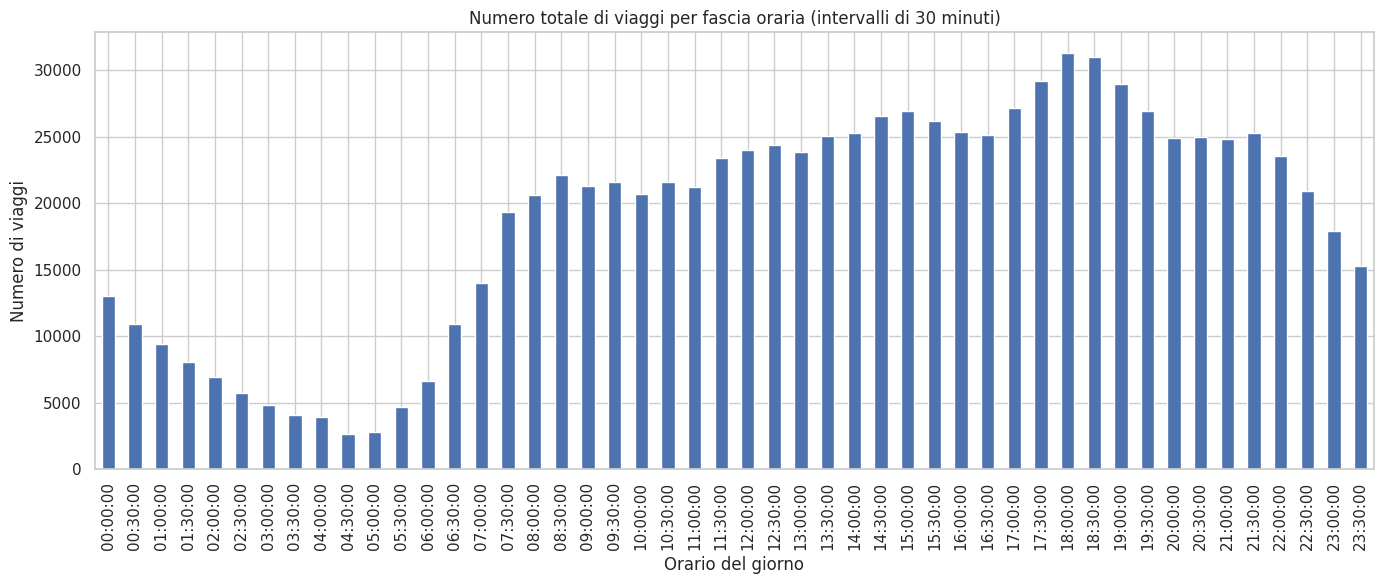

In [17]:
# Step 7 - Cluster the pickup time of the day into 30-minute intervals
df["pickup_time_only"] = df["tpep_pickup_datetime"].dt.time
df["pickup_half_hour"] = df["tpep_pickup_datetime"].dt.floor("30min").dt.time
pickup_time_counts = df["pickup_half_hour"].value_counts().sort_index()
plt.figure(figsize=(14, 6))
pickup_time_counts.plot(kind="bar")
plt.title("Numero totale di viaggi per fascia oraria (intervalli di 30 minuti)")
plt.xlabel("Orario del giorno")
plt.ylabel("Numero di viaggi")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
# 8. Average passengers and fare per interval
avg_passengers_fare = df.groupby("pickup_half_hour")[["passenger_count", "fare_amount"]].mean().reset_index()


In [19]:
#1	Credit card
#2	Cash
#3	No charge
#4	Dispute

In [20]:
# 9. Average fare per payment type and interval
avg_fare_by_payment_interval = df.groupby(["payment_type", "pickup_half_hour"])["fare_amount"].mean().reset_index()


In [21]:
# 10. Max fare interval per payment type
max_fare_interval = avg_fare_by_payment_interval.loc[avg_fare_by_payment_interval.groupby("payment_type")["fare_amount"].idxmax()]


In [22]:
# 11. Max tip/fare ratio per interval and payment type
df["tip_ratio"] = df["tip_amount"] / df["fare_amount"]
df = df.replace([np.inf, -np.inf], np.nan)
valid_tip_ratio = df.dropna(subset=["tip_ratio"])
avg_tip_ratio = valid_tip_ratio.groupby(["payment_type", "pickup_half_hour"])["tip_ratio"].mean().reset_index()
max_tip_ratio = avg_tip_ratio.loc[avg_tip_ratio.groupby("payment_type")["tip_ratio"].idxmax()]
print("Massimo rapporto mancia/tariffa per ciascun payment_type:")
print(max_tip_ratio)


Massimo rapporto mancia/tariffa per ciascun payment_type:
     payment_type pickup_half_hour  tip_ratio
3             1.0         01:30:00   1.943246
60            2.0         06:00:00   0.000187
113           3.0         08:30:00   0.033119
164           4.0         10:00:00   0.041353


In [23]:
# 12. location with the highest average fare amount
highest_avg_fare_loc = df.groupby("PULocationID")["fare_amount"].mean().idxmax()
print(f"Pickup location con la tariffa media più alta: {highest_avg_fare_loc}")

Pickup location con la tariffa media più alta: 180


In [24]:
# 13. common df
top_dests = df.groupby(["PULocationID", "DOLocationID"]).size().reset_index(name="count")
top5 = top_dests.groupby("PULocationID").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)
common = pd.merge(df, top5[["PULocationID", "DOLocationID"]], on=["PULocationID", "DOLocationID"])

<ipython-input-24-cf8cbae43faf>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = top_dests.groupby("PULocationID").apply(lambda x: x.nlargest(5, "count")).reset_index(drop=True)


In [25]:
# 14. Average fare in 'common'
common_avg = common.groupby(["payment_type", "pickup_half_hour"])["fare_amount"].mean().reset_index()

In [26]:
# 15. Difference and 16. Ratio with global average
fare_diff = pd.merge(
    avg_fare_by_payment_interval,
    common_avg,
    on=["payment_type", "pickup_half_hour"],
    suffixes=("_all", "_common"),
    how="left")
fare_diff["difference"] = fare_diff["fare_amount_common"] - fare_diff["fare_amount_all"]
fare_diff["ratio"] = fare_diff["difference"] / fare_diff["fare_amount_all"]


In [27]:
# 17. Build chains of trips
sorted_df = df.sort_values(by=["VendorID", "tpep_pickup_datetime"])
sorted_df["prev_dropoff_time"] = sorted_df.groupby("VendorID")["tpep_dropoff_datetime"].shift()
sorted_df["prev_dropoff_loc"] = sorted_df.groupby("VendorID")["DOLocationID"].shift()
sorted_df["chain_start"] = (
    (sorted_df["PULocationID"] == sorted_df["prev_dropoff_loc"]) &
    (sorted_df["tpep_pickup_datetime"] > sorted_df["prev_dropoff_time"]) &
    ((sorted_df["tpep_pickup_datetime"] - sorted_df["prev_dropoff_time"]).dt.total_seconds() <= 120)
)
sorted_df["chain"] = sorted_df["chain_start"].cumsum()

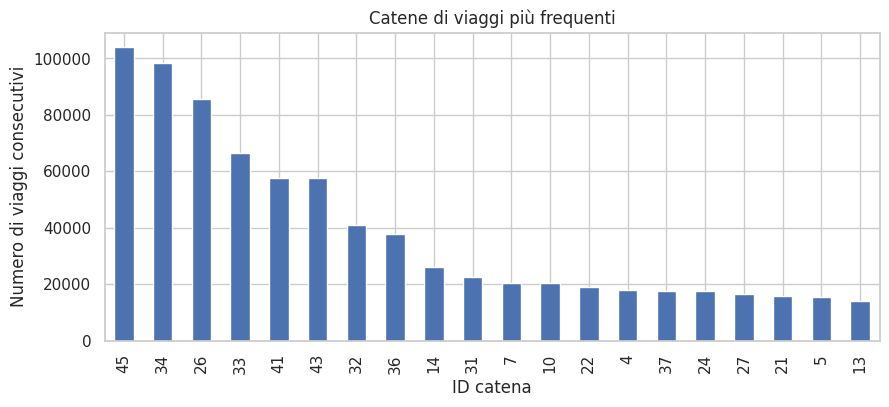

In [28]:
# Visualizzazione aggiuntiva: catene
plt.figure(figsize=(10, 4))
sorted_df["chain"].value_counts().head(20).plot(kind="bar")
plt.title("Catene di viaggi più frequenti")
plt.xlabel("ID catena")
plt.ylabel("Numero di viaggi consecutivi")
plt.show()